<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Connecting_MonteCarlo_to_ModernAI/02_2D_Ising_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 2: 2D Ising Model
Ashley Dale


---


In this notebook, you will learn the following concepts:
*   The Ising model for ferromagnetic systems
*   How to implement the Metropolis-Hastings algorithm for a 2D Ising Lattice
*   How to evaluate the efficiency of your code and time the execution
*   How to speed up your code so that you can run larger simulations using the same computational resources

#### Setup Python Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import timeit
from numba import jit
import copy

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

#Background Information




## Ising Hamiltonian for Ferromagnetic 2D System

*Note: For a very good reference on this derivation (and where much of this notation comes from), [see here](https://farside.ph.utexas.edu/teaching/329/lectures/node110.html).  Other good references can be found in the "Additional Readings" section.*

Consider a system of ferromagnetic atoms, where each atom initially has spin up (+1) or down (-1).  Ferromagnetic means that the system wants to align all of the spins in the same direction to minimize energy, so that all of the spins should be up or all of the spins should be down.  If the net-magnetization of the system is zero, all of the spins cancel each other out.  If the net-magnetization of the system is greater than zero, then some percentage of the magnetic spins are aligned.

**We want to be able to study the phase transition of the system from disordered (spins randomly oriented) to ordered (spins aligned), and vice versa.**  In order to do this, let's arrange the spins onto the grid points of a lattice as shown in the figure below.  Note that the picture shown is for a 2D system, but any useful dimensionality can be done.

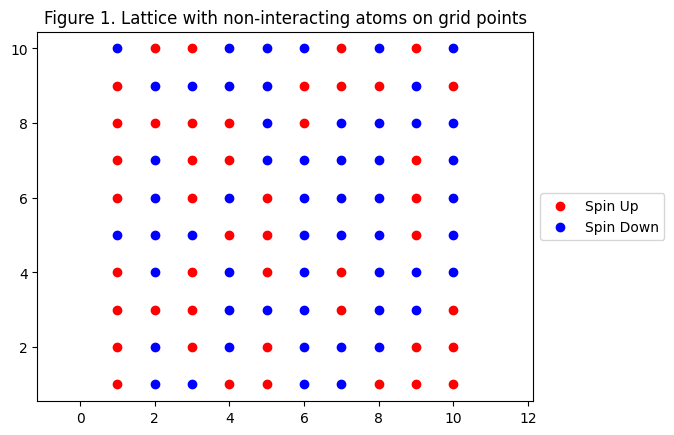

In [3]:
# Code to show an example lattice with non-interacting spins
spin_up_or_down = np.random.choice([0,1], size=(10,10))
xv, yv = np.meshgrid(np.linspace(1, 10, 10), np.linspace(1, 10, 10))
fig, ax = plt.subplots(1, 1)
ax.scatter(xv[np.reshape(spin_up_or_down, (10, 10)) == 1],
            yv[np.reshape(spin_up_or_down, (10, 10)) == 1],
            c='r', label="Spin Up")
ax.scatter(xv[np.reshape(spin_up_or_down, (10, 10)) == 0],
            yv[np.reshape(spin_up_or_down, (10, 10)) == 0],
            c='b', label="Spin Down")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axis('equal')
plt.title("Figure 1. Lattice with non-interacting atoms on grid points")
plt.show()

To determine the energy of the $i^{th}$ atom in the system above, we start with the energy of the atom in a magnetic field

<center>$\epsilon_i = \mu H \sigma_i$</center>

where $\mu$ is the atomic magnetic moment, $H$ is an applied magnetic field, and the $\sigma$ operator "measures" the spin of the atom and returns value $+1$ for spin up or $-1$ for spin down.

Next, lets add a nearest-neighbors interaction between the particles, with strength $J$:

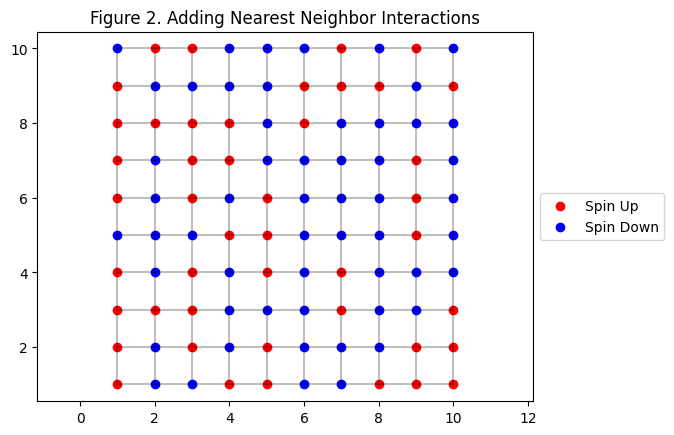

In [4]:
# Code to show add nearest-neighbors interactions to the above figure
fig, ax = plt.subplots(1, 1)

for x, y in zip(xv, yv):
    ax.plot(x, y, 'k', alpha=0.25)
    ax.plot(y, x, 'k', alpha=0.25)
ax.scatter(xv[np.reshape(spin_up_or_down, (10, 10)) == 1],
            yv[np.reshape(spin_up_or_down, (10, 10)) == 1],
            c='r', label="Spin Up")
ax.scatter(xv[np.reshape(spin_up_or_down, (10, 10)) == 0],
            yv[np.reshape(spin_up_or_down, (10, 10)) == 0],
            c='b', label="Spin Down")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axis('equal')
plt.title("Figure 2. Adding Nearest Neighbor Interactions")
plt.show()

To include the energy from each site interacting with the $i$th atom, we can update the above expression:

<center>$\epsilon_i = -\frac{1}{2}J\sum_{j\in[1,4]} \sigma_i \sigma_j + \mu H \sigma_i$</center>

where
- the $\frac{1}{2}$ factor ensures that we don't double count the contributions from neighboring atoms.
- $J$ is the coupling between nearest neighbors (the gray lines in Figure 2)
- The negative sign "$-$" in front of the $J$ means that this is a ferromagnetic system
- $j$ means that only four nearest neighbors for each atom in Figure 2 will be included in the calculation


It's important to note here, that the $\sigma_i$ term can be pulled out of the sum and we can divide by the magnetic moment:

<center>$ -\frac{1}{2 \mu}J$<font color='red'>$\sigma_i$</font>$ \sum_{j\in[1,4]} \sigma_j$</center>

So that the total energy for the $i$th spin can be written as

<center>$\epsilon_i = \mu \sigma H_{eff}$</center>

where

<center>$H_{eff} = -\frac{1}{2 \mu}J \sum_{j\in[1,4]} \sigma_j + H$</center>

which means that for atom $i$, the only difference in energy for the atom in a spin up state or spin down state is a $+$ or $-$ sign:

<center>$\epsilon_i\{\sigma_i, UP\} = - \epsilon_i\{\sigma_i, DOWN\}$</center>

To get the total energy for the system, we sum over all the measured of the observed energies:

<center>$E = \sum_i \epsilon_i$</center>.

Using this Hamiltonian, we want to understand the expected spin value given the temperature of the system.  The probability $p$ that a spin has a particular value can be calculated using the [Maxwell-Boltzmann distribution](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Kinetics/03%3A_Rate_Laws/3.01%3A_Gas_Phase_Kinetics/3.1.02%3A_Maxwell-Boltzmann_Distributions)

<center>$p_{i,\pm} = \frac{e^{\mp \epsilon_i/k_BT}}{\sum_i e^{\epsilon_i /k_B T}} $</center>

where $\epsilon_i$ is the energy of the atom, and $k_BT$ is the energy environment (also referred to as a temperature bath) of the atom.  The denominator of the fraction normalizes the probability distribution, so that there is a max probability of 1.

The average value of the magnetic moment of the atom for a given temperature is

<center>$\langle \mu \rangle = \frac{\mu p_+ + (-\mu)p_-}{p_+ + p_-}$</center>

After plugging in the expression for the probability and evaluating the $\sigma_i$ operators appropriately, we get

<center>$\langle \mu \rangle = \mu \frac{e^{- \mu H/k_BT} - e^{+ \mu H /k_BT}}{e^{- \mu H/k_BT} + e^{+ \mu H/k_BT}} = \mu$ tanh($\frac{\mu H}{k_B T}$)</center>

**This is not an expression we can solve analytically, but it can be solved numerically.**

## Metropolis-Hastings Algorithm Walk-through

This algorithm has multiple variations in addition to "[Metropolis-Hastings](https://pubs.aip.org/aip/jcp/article-abstract/21/6/1087/202680/Equation-of-State-Calculations-by-Fast-Computing?redirectedFrom=fulltext)", such as "[Stochastic Simulated Annealing](https://machinelearningmastery.com/simulated-annealing-from-scratch-in-python/)" and "[Sequential Simulated Annealing](https://link.springer.com/article/10.1007/s10898-011-9838-3)".  The "simulated annealing" comes from the idea that the system begins in a random state that is equivalent to the system being at infinitely high temperature. The system is then "submerged" into a bath of temperature $T$ where $T$ is a finite temperature that "cools" the system off.

---

0. Initialize the system with the following variables:
    - $T$: temperature of the "bath" which will anneal the system
    - $N$: the size of the system
    - $s$: the state of each particle in the system
    - $J$: the coupling between particles in the system
    - $H$: the applied magnetic field
1. Select an atom in the system
2. Calculate the energy $e_i$ of that atom
3. Determine if changing the spin of the atom would decrease the energy
4. If it decreases the energy **OR** if the probability of the state in the Boltzmann distribution is greater than a sample from a uniform probability distribution, then change the spin state of the atom.
5. Continue with steps 1-4 until the stopping criteria is met.
6. Return to step 0 and re-initialize the system with different variables as desired.
---
Let's go through these steps in code:

**Step 0: Initialize the lattice and the simulation**

I want a square, 10x10 lattice (N = 100).  By calling the `np.random.uniform()` function, I know I will get an uniform distribution of values between 0 and 1

In [ ]:
lattice = np.random.uniform(size=(10,10))

Next, I want to prepare the system into spin up and spin down

In [ ]:
lattice[lattice>0.5]=1 # any values greater than 0.5, I set equal to 1
lattice[lattice !=1]=-1 # anything I don't change before, I make equal to -1

Last thing for the lattice is to visually check and see if everything turned out okay.  Every value in the lattice should be $+1$ or $-1$.

In [ ]:
plt.imshow(lattice)
plt.colorbar()
plt.show()

Next, I am going to create a temperature variable.  In the equations above, the inverse temperature is represented by $1/k_B T$, where $k_B$ is the Boltzmann constant.  If $T = ∞$, then the inverse temperature will zero, and if $T=0$ then the inverse temperature will be $∞$.  Accordingly, we can define:

<center>$\beta = 1/k_B T$</center>

where we can artificially restrict $\beta \ge 0$ to make calculations simple.  We already know what the system is like at infinite temperature because we are starting out in a thermalized state, so this way as $T → 0$, $\beta$ will become very large.  For now, let's start with $\beta=0$, just to make sure things are working.

In [ ]:
beta = 0 # thermodynamic inverse temperature variable

For right now, I'm going to set $H=0$, $J=1$, and $\mu=1$.  This means I can omit them from my code, and proceed to step 1 of the algorithm.

**Step 1: Select an atom in the system**

This is where I need to make another coding decision.  If I start with the atom at location (0, 0), then there are no neighbors located at (-1, 0) and (0, -1) because of how ```numpy``` matrices are indexed.  This same thing will happen for all of the other atoms at the edges of my lattice: they are missing neighbors.  So for right now, I will start in the *second* row and *second* column, then stop at the *second-to-last* row and *second-to-last* column.  I won't be able to update the edge atoms with the lower energy configurations, but my code will run for right now.

**(Steps 2-5 are in the code comments)**

In [ ]:
# --> Step 1: double for-loop
for r in range(1,9): # the range is from (1,9) instead of (0, 10)
  for c in range(1,9): # the range is from (1,9) instead of (0, 10)

        # --> Step 2: Calculate the energy of the atom
        # the sum over the nearest neighbors is completed first to make it easy to check
        sum_NN = (lattice[r-1,c]+lattice[r+1, c]+lattice[r,c+1]+lattice[r,c-1])

        # then the total energy for the atom is calculated
        E_a = -0.5*lattice[r,c]*sum_NN

        # --> Step 3: Change the spin and re-calculate the energy
        # Remember we said above that changing the spin just changes the sign
        # of the energy
        E_b = -1*E_a

        # --> Step 4: If the energy decreased or the probability sample
        # meets the requirement
        if E_b < E_a or np.exp(-(E_b - E_a)*(beta)) > np.random.rand():
            # Update the actual spin value in the lattice
            lattice[r, c] *= -1

        # --> Step 5: The stop condition for this code block is that all of the
        # interior atoms have been updated at least once

Next, I'm going to visualize my system again to see if anything changed.  Since I set the thermodynamic temperature at $\beta=0 → T = \infty$, it should still be in a mixed state.

In [ ]:
plt.imshow(lattice)
plt.colorbar()
plt.show()

Above, we implemented a Monte Carlo Markov Chain (MCMC) to update the atom's spin state.  The state transition was considered based on sampling from both the Boltzmann distribution and the uniform distribution.  The MCMC simulation allowed us to implement the Hamiltonian model for how we think the sytem should behave.

### Example Temperature Experiment
So far, so good!

Let's make some improvements to the code, and simulate the model for a range of temperatures.

In the code below, the variable `sqrt_N` = $\sqrt{N}$.  Since we have $N$ atoms in the system, the lattice has dimension $\sqrt{N} \times \sqrt{N}$.

In [ ]:
# Making the lattice a little larger
sqrt_N = 25

# Create a new lattice
init_lattice = np.random.uniform(size=(sqrt_N,sqrt_N))

#mask lattice
init_lattice[init_lattice>0.5]=1
init_lattice[init_lattice !=1]=-1

# A new step here to create non-interacting atoms around the edge by padding
# the array edges with zeroes.  This way, we can iterate over all N atoms in the
# system without causing an out-of-bounds error
lattice = np.zeros((sqrt_N+2, sqrt_N+2))
lattice[1:sqrt_N+1, 1:sqrt_N+1] = init_lattice

# Define a range of temperatures to test
beta = np.linspace(0, 2, 1000)

# Empty variable to hold the magnetism calculations
M = []

# For each temperature
for temp in tqdm(beta):

    # Repeat the MCMC step 100 times to make sure the system is stable
    for n in range(100):

        [rows, cols] = lattice.shape # Figure out the size of the lattice

        for r in range(1,rows-1): # keep the neighbors inside the region
            for c in range(1,cols-1):

                # sum over the nearest neighbors
                sum_NN = (lattice[r-1,c]+lattice[r+1, c]+lattice[r,c+1]+lattice[r,c-1])

                # calculate the energy
                E_a = -0.5*lattice[r,c]*sum_NN

                # re-calculate the energy for a spin state change
                E_b = -1*E_a

                # choose whether to keep the new state or not
                if E_b < E_a or (np.exp(-(E_b - E_a)*temp) > np.random.rand()):
                    lattice[r, c] *= -1

    # After the system is stable, calculate the net magnetism by summing over
    # all of the spin values and averaging them
    M.append(np.abs(np.sum(np.sum(lattice)))/(sqrt_N*sqrt_N))

100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


Plot the final lattice to see how the overall spin state has changed:

In [ ]:
plt.imshow(lattice)
plt.colorbar()
plt.show()

We can also plot the net-magnetism as a function of temperature, as shown below:

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(beta, M, s=1)
ax.set_xlabel(r"Inverse Temperature $\beta$", )
ax.set_ylabel("Net Magnetism M")
plt.show()

The plot above shows a noisy transition from 0 net magnetism at $\beta=0$ (or $T=\infty$), to completely magnetized by $\beta=2$.  The phase transition resembles the [$tanh$](https://mathworld.wolfram.com/HyperbolicTangent.html) function, but centered around 1.

## Optimizing Your Algorithm Execution

The code above takes a few minutes to run for even a fairly small system.  We want to optimize the code to make it as fast as possible so that we can repeat our results many times to make sure they are reliable, study larger systems, and use computational resources wisely.

Optimizing code requires two different types of analysis:

1. **Complexity analysis.**  This approach considers the number of commands required to finish your simulation, and can be used to estimate the amount of time it takes to run your code before you run it.  Complexity analysis leverages mathematical cleverness to solve a problem using the fewest number of steps possible.  It does not depend on what programming language you use, or what computer your code will run on, which makes it a very powerful and flexible technique.  [For a good introduction, see here.](https://discrete.gr/complexity/)

2. **Execution optimization.** This approach considers how to best use the hardware resources available to you, so it requires an understanding of both the different code libraries and languages you are using, and how the hardware uses these libraries to return your result.  Significant improvements can be made, but it can be difficult to reduplicate the optimization for your algorithm on another machine or in a different programming language.

Execution optimization is more challenging than complexity analysis and is hardware specific, so in general you will want to start with complexity analysis, and then add execution optimization as the second optimization step.

### Complexity Analysis

To gain an understanding of complexity analysis, let's start by looking at a function that defines just the MCMC step.  Prepare to dust off your counting skills:

---
```
1. def MCMC_step(T: int, lattice: np.array):
2.     [rows, cols] = lattice.shape
3.     for r in range(1,rows-1):
4.         for c in range(1,cols-1):
5.             sum_NN = (lattice[r-1, c]+
                         lattice[r+1, c]+
                         lattice[r, c+1]+
                         lattice[r, c-1])
6.             E_a = -0.5*lattice[r,c]*sum_NN
7.             E_b = -1*E_a
8.             if E_b < E_a:
9.                 lattice[r, c] *= -1
10.             elif np.exp(-(E_b - E_a)*T) > np.random.rand():
11.                lattice[r, c] *= -1
12.    return lattice
```
---

We want to try and *estimate* how many commands happen inside this function.  The actual number of commands is not as important as gaining intuition about what parts of the code take the most time to run.  We want to find the slowest things first, so that we can fix them the fastest.  Use the following guide lines to help with the analysis:



**1. Work from inside nested code to outside nested code.**

**2. Corollary: Find the ```for``` loops first.**

There are two ```for``` loops defined, on lines 3 and 4, and the ```for``` loop on line 4 is inside the ```for``` loop on line 3.

- The ```for``` loop on line 4 repeatedly executes commands on lines 5-11.  Since these commands have a constant number of steps, where the number of steps does not depend on the input arguments to the function, we can say that there are $C_1$ commands for lines 5-11, and the total number of commands $T$ for lines 5-11 is
<center>$T_{5:11} = C_1$</center>

- Now, because there is a ```for``` loop on line 4, we know that the commands on lines 5-11 will be repeated for $x = (cols-1) - 1$ times, because that is the number of iterations of the line 4 ```for``` loop, where the index variable ```c``` goes through the different column values of the lattice.  Furthermore, we can tell from line 2 that the value of ```cols``` depends on the input argument to this function.  So when including the command on line 4, we will want to use a variable $x$ for the number of times this ```for``` loop executes, and the total number of commands becomes
<center>$T_{4:11} = C_1  x$</center>

- Next, we need to consider the ```for``` loop on line 3.  For this notebook, we will only use square matrices, which means that the number of rows and columns will be the same, and the ```for``` loop on line 3 will execute $x$ times, the same as the loop on line 4.  The total number of commands increases to
<center>$T_{3:11} = C_1x^2$ </center>

- Finally, we need to account for the command on line 2.  This command is expected to have a constant run time because it is returning the shape of the input, and returning the shape requires the same calculations regardless of what the shape actually is.  Therefore, we can say that the number of commands for line 2 is $C_2$.  We can omit lines 1 and 12 because they initialize and exit the function, so the total time is
<center>$T = C_1x^2 + C_2$</center>


**Here's what we know from this analysis**

- **The primary parameter controlling the speed of this algorithm is the size of the lattice that we are simulating.**  The $x$ value is the number of rows/columns in the system.  The value of the other parameter, $T$, does not change how fast or slow the code is.

- **The slowest part of the code will be the nested for-loop.**  The nested for-loop structure is why we have the highest power term in $T$ is the $x^2$.  This is a *polynomial run time*, which means that if we change from a $10\times10$ lattice to a $20\times20$ lattice, we should expect the time it takes to run the code to approximately quadruple.  This can be shown mathematically as follows:
<center>$T_1(x=10) = 100C_1 + C_2$</center>
<center>$T_2(x=20) = 400C_1 + C_2$</center>
<center>$T_2 \approx 4 T_1$</center>

---
*TLDR: In general, good coding practices means you will repeat a command as few times as possible. **DON'T** put anything inside a for-loop (i.e. a variable initialization) unless it absolutely must be there, and be careful using for-loops in the first place.*
---

This function is already very minimal, which means that to optimize it further we need to consider how it can be executed on the hardware.

### Execution Optimization

Before we get started optimizing, here are some things to know:

- [Computers convert every programming language to machine code in the end.](https://www.cs.mtsu.edu/~xyang/2170/computerLanguages.html)  However, the compiler a computer uses to do this conversion can make a huge difference in how quickly your code runs.

- [Python is an interpreted language,](https://www.scaler.com/topics/why-python-is-interpreted-language/) which means that every time a line of code is executed the computer pretends it has never compiled it before (even if it has, as in the case of a `for` loop).  This means Python is easy to read and easy to change as you work, but the flexibility slows the computer down.  Python was designed to be human-friendly, not computer-friendly.

- The big Python data science libraries like NumPy, SciPy, SciKit-Learn, TensorFlow/Keras, and PyTorch have typically undergone execution optimization to make them as fast as possible.  For example, [NumPy uses the C programming language to speed up calculations; calculations actually aren't executed in Python because C has a very good compiler.](https://numpy.org/doc/stable/dev/internals.code-explanations.html)  As a scientist, sometimes you will need decide whether to choose the speed gained by using a pre-optimized function, or the transparency that comes from coding your own version.

- Python libraries for visualization like Matplotlib and Pandas will always be slower than libraries used for calculation, even if they have some calculation functionality included (*cough* Pandas *cough*).  Keep this in mind when deciding where in your code to generate plots.


#### Execution Optimization Toolkit
Here are some common tools useful for analyzing how your code runs. These tools focus on optimizing *speed* and *memory*; there are other tools for optimizing other aspects of programming like [documentation](https://docs.python.org/3/library/pydoc.html) and [code consistency](https://www.techbeamers.com/pylint-tool/).

|What you are optimizing|What you use to optimize it| How it works
| --- | --- | --- |
|Speed|[timeit](https://docs.python.org/3/library/timeit.html)|Measures how long a code snippet takes to execute|
|Speed|[tqdm](https://tqdm.github.io/)|Measures how long a loop takes to execute *with a loading bar!!!*|
|Memory|[memory-profiler](https://pypi.org/project/memory-profiler/#description)|See which variables and programs use what memory resource |

Note that these are diagnostic tools that provide a way to measure what the computer does with your code.  It is still up to you to find solutions to slow parts or out-of-memory (OOM) errors and implement them.

# Exercises

Complete the exercises below.

## Programming Exercise 1: Optimize the Speed of the Metropolis-Hastings Algorithm


### 1a) Complete the functions `intialize_lattice` and `MCMC_step`

... using the information provided above and the commented hints in the function templates provided below.  Feel free to copy code from above as you fill in the blanks, but be careful!  Some variable names have been changed...

In [ ]:
# Complete the initialize_lattice function below

def initialize_lattice(sqrt_n: int):
    """
    Function to initialize lattice.  Adds a border of zeros
    to represent non-interacting atoms and make the neighbor
    calculation easier

    sqrt_n: The square root of the number of atoms in the lattice
    returns padded_lattice: A lattice of size (sqrt_n+2, sqrt_n+2)
    """

    # initialize the lattice using np.random.random for a lattice of size
    # sqrt_n x sqrt_n

    new_lattice =

    # create a lattice of zeros that has an extra row on the top and bottom,
    # and an extra column on the left and the right

    padded_lattice =

    #mask lattice by setting values above 0.5 to 1, and everything else to -1
    new_lattice[new_lattice>0.5] =
    new_lattice[new_lattice!=1] =

    # added step to create non-interacting atoms
    padded_lattice[1:sqrt_n+1, 1:sqrt_n+1] =

    return np.array(padded_lattice)

In [ ]:
# Complete the MCMC_step function below

def MCMC_step(beta: float, lattice: np.array):
    """
    Function to repeat the Monte Carlo Markov Chain for this system.
    beta: the inverse temperature value for the MCMC step
    lattice: the system of spins that will be simulated
    returns: an updated version of the input lattice
    """

    # Figure out the size of the lattice
    [rows, cols] = lattice.shape

    # keep the neighbors inside the region
    for r in range(1,rows-1):
        for c in range(1,cols-1):

            # sum over the nearest neighbors
            sum_NN =

            # calculate the energy
            E_a =

            # re-calculate the energy for a spin state change
            E_b = -1*E_a

            # choose whether to keep the new state or not
            if #<ENTER LOGIC STATEMENT HERE>
                lattice[r, c] *= -1

    return lattice

### 1b) Perform the following experiment

By calling the `main_exercise1b` function using different arguments:

1. Re-run the simulation for lattice sizes of $\sqrt{N}$ = [10, 15, 20, 25, 40].
2. For each simulation of $\sqrt{N}$ values, record how long it took to run.  Use `timeit` and/or `tqdm` to measure the how long the code takes to run. (What is the difference between the reported values if you use both?)
3. Make a plot showing how the time it took to run depends on the size of the simulation.
4. Make a plot showing the net-magnetization curves for each system size.

The function `main_exercise1b` is provided for you below; it calls the two functions you just completed.

>Note: This computation may take some time to complete.  Discuss with your instructor how long you should wait for a simulation to run.

In [ ]:
def main_exercise1b(sqrt_N: int):
    """
    Main function to complete a simple Metropolis-Hastings Ising model
    experiment.

    sqrt_N: integer that is the square root of the number of atoms in the system

    returns [inverse_temperature, M]: where M is the net magnetization at each
            temperature
    """

    spin_lattice = initialize_lattice(sqrt_N)

    inverse_temperature = np.linspace(0, 2, 1000)

    M = [] #empty variable to hold net magnetism

    # For each temperature
    for beta in tqdm(inverse_temperature):

        # Repeat the MCMC step 100 times to make sure the system is stable
        for n in range(100):

            spin_lattice = MCMC_step(beta, spin_lattice)

        M.append(np.abs(np.sum(np.sum(spin_lattice)))/(sqrt_N*sqrt_N))

    return inverse_temperature, M

Call the main function in the code cell below like this.
```
start = timeit.default_timer()
beta_N5, M_N5 = main_exercise1b(5)
print("\nTime to completion for N = 5: "+str(timeit.default_timer() - start))
```
Make sure to keep the `beta` and `M` values for plotting.

In [ ]:
# Enter your code to call the main function here.  You can either
# call the function multiple times in one cell, or add code cells
# for each call




In [ ]:
# Manually enter your results for each run here:
num_atoms = []
measured_time = []

In [ ]:
# Put your plotting code here


### 1c) Optimize the code to see if you can reduce the time it takes to run.

0. Copy-paste the `MCMC_step` function from above into the empty code cell below.  We are going to modify it to make it faster, but we also want to keep the original for reference.  Rename the function `MCMC_step_optimized`.

1. Add a `numba` "decorator" to the line just above the function declaration.  It should look like this:
```
@jit()
def MCMC_step_optimized(beta: float, lattice: np.array):
...
```
The `@jit()` decorator comes from the `numba` python package and, when placed before the function, tells the Python compiler to treat this code like a statically compiled C object. The first time the function is called, it won't show any improvement because it isn't compiled yet.  However, the second time the function is called, the compiled version should still be in memory, and we will see some improvements.

In [ ]:
# Copy-paste the MCMC_step function from above here



2. A slightly altered main function `main_exercise1c` is provided for you here.  No need to change anything.  Just call it the same way you did before.
```
start = timeit.default_timer()
beta_N5, M_N5 = main_exercise1c(5)
print("\nTime to completion for N = 5: "+str(timeit.default_timer() - start))
```

In [ ]:
#from tqdm.gui import tqdm_gui
# Here is a slightly altered main function for you

def main_exercise1c(sqrt_N: int):
    """
    Main function to complete a simple Metropolis-Hastings Ising model
    experiment.

    sqrt_N: integer that is the square root of the number of atoms in the system

    returns [inverse_temperature, M]: where M is the net magnetization at each
            temperature
    """

    spin_lattice = initialize_lattice(sqrt_N)

    inverse_temperature = np.linspace(0, 2, 1000)

    M = np.zeros(1000) #empty variable to hold net magnetism

    # For each temperature
    for t in range(len(inverse_temperature)):
        beta = inverse_temperature[t]

        # Repeat the MCMC step 500 times to make sure the system is stable
        for n in range(500):

            spin_lattice = MCMC_step_optimized(beta, spin_lattice)

        M[t] = (np.abs(np.sum(np.sum(spin_lattice)))/(sqrt_N*sqrt_N))

    return inverse_temperature, M

3. Repeat the experiment with the same values for $\sqrt{N}$ from above, and record the new time values.  Create a two more plots to compare with the ones created above (Time vs $\sqrt{N}$, and Net Magnetization vs Temp), and compare them with the plot from earlier.  Answer these questions:

- What things are the same in the Net Magnetization plot?
- What things are different in the Timing plot?
- How effective is using the `numba` package at improving your code?

In [ ]:
# Call the optimized version of the functions here:


In [ ]:
# Create plotting code here

## Programming Exercise 2: Study of Magnetic Domain Formation

Now that we have code up and running for a large system efficiently, let's watch some magnetic domains form.  Complete the following experiment:

1. Write a new main function `main_exercise2` by making the following changes to `main_exercise1c`:
    - create a new `list` variable: `lattice_at_T`.  This variable will hold a set of lattices at different temperatures
    - update the `lattice_at_T` variable after the net magnetism `M` is calculated by appending the `spin_lattice` to the list.
    - return the `lattice_at_T` variable along with the `inverse_temperature` and `M` variables
    - A template is started for you below.

2. Choose the largest value of `N` that you can simulate within a reasonable amount of time.  Use the code in *Exercise 1C* to figure out how large to go.

3. Execute the new `main_exercise2` function.  Save all three outputs.

4. Plotting code is created for you below.

In [ ]:
# Template to get you started
def main_exercise2(sqrt_N: int):
    """
    Main function to complete a simple Metropolis-Hastings Ising model
    experiment.

    sqrt_N: integer that is the square root of the number of atoms in the system

    returns [inverse_temperature, M]: where M is the net magnetization at each
            temperature
    """

    spin_lattice =

    inverse_temperature = np.linspace(0, 2, 1000)

    #empty variable to hold net magnetism
    M = []

    # --> Declare new variable to hold spin lattices here


    # For each temperature
    for beta in tqdm(inverse_temperature):

        # Repeat the MCMC step 500 times to make sure the system is stable
        for n in range(100):

            spin_lattice = MCMC_step_optimized(beta, spin_lattice)

        M.append(np.abs(np.sum(np.sum(spin_lattice)))/(sqrt_N*sqrt_N))

        # --> Update the lattice array here


    return inverse_temperature, M, # Add returned argument here

In [ ]:
# Call the function above here
beta, mag, lattices =

In [ ]:
# You should be able to just run this cell and the next directly
fig, ax = plt.subplots(1, 1)
ax.plot(beta, mag)
ax.set_xlabel(r"Inverse Temperature $\beta$")
ax.set_ylabel("Net-magnetism M")
plt.show()

In [ ]:
def plot_mag_domains(x):
    plt.figure(2)
    plt.imshow(lattices[x])
    plt.title(r"$\beta$ = "+str(beta[x]))
    plt.show()

interactive_plot = interactive(plot_mag_domains, x=(0,999))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

### Answer the following questions:

Explore the set of simulated lattices above using the slider, and see if you can detect changes in the magnetic domains generated.  Edit this cell with your answers to the questions.

1. At what inverse temperature $\beta < 1$ do you notice a significant change in the lattice domain states?

> **Answer:**

2. How does this compare to the plotted values?

> **Answer:**

3. How would you describe the shapes of the domains that form at $\beta \in [0.75, 0.85]$?

> **Answer:**

4. Do you have a lattice that is completely aligned?  For what $\beta$ value?  Is there one that is close?

> **Answer:**

# Additional Readings

1. [Jeffery Chang. "1D Ising Model Derivation". 2019](https://stanford.edu/~jeffjar/statmech/lec4.html)

2. [LibreTexts Chemistry. "Review of Maxwell-Boltzmann Calculations". N.D.](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Kinetics/03%3A_Rate_Laws/3.01%3A_Gas_Phase_Kinetics/3.1.02%3A_Maxwell-Boltzmann_Distributions)

3. [A ~5 minute guide to Numba](https://numba.readthedocs.io/en/stable/user/5minguide.html)

4. [How to optimize for speed](https://scikit-learn.org/stable/developers/performance.html)

5. [Python Memory Profilers](https://stackify.com/top-5-python-memory-profilers/)

6. [How to Optimize Python Code](https://stackify.com/how-to-optimize-python-code/)